In [6]:
import os, glob, re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import pandas as pd


In [7]:
def get_experiment(hash, experiment_dir):
    path = f"data/{hash}/{experiment_dir}"
    all_data = []
    
    # get all experiment directories
    experiment_dirs = glob.glob(f"{path}/experiment_*")
    
    for exp_dir in experiment_dirs:
        exp_name = os.path.basename(exp_dir)
        session_dirs = glob.glob(f"{exp_dir}/*TrainingSession_*")
        exp_data = {'experiment_name': exp_name}
        
        for session_dir in session_dirs:
            #get first word (e.g., "SNNTrainingSession" -> "SNN")
            session_type = os.path.basename(session_dir).split('Training')[0]            
            
            
            with open(os.path.join(session_dir, "metrics.json"), 'r') as f:
                metrics = json.load(f)
                
                
            #TODO: NEED TO COMPUTE CF METRICS BY SELF !!!!
            with open(os.path.join(session_dir, "cf_metrics.json"), 'r') as f:
                cf_metrics = json.load(f)
                
            for k, v in metrics.items():
                exp_data[f"{session_type}_{k}"] = v
            for k, v in cf_metrics.items():
                exp_data[f"{session_type}_{k}"] = v
                
        all_data.append(exp_data)
    
    df = pd.DataFrame(all_data)
    
    return df


In [279]:
def compute_omega_base(alpha_ideal, num_training_sessions, alphas):
    T = num_training_sessions
    omega_base = np.sum(alphas[1:])#skip the first session like in the paper
    omega_base /= ((T-1) * alpha_ideal)
    return omega_base
    
def compute_omega_all(alpha_ideal, num_training_sessions, alphas):
    T = num_training_sessions
    omega_all = np.sum(alphas)
    omega_all /= ((T-1)  * alpha_ideal)
    return omega_all

def compute_omega_new(alpha_ideal, num_training_sessions, alphas):
    T = num_training_sessions
    omega_new = np.sum(alphas)
    omega_new /= (T-1)
    return omega_new

def compute_omega(metric_key, alpha_ideal, num_sessions, baseline_sessions, model_sessions):
    functions = {
        'base': compute_omega_base,
        'all': compute_omega_all,
        'new': compute_omega_new
    }
    func = functions.get(metric_key)
    
    if func:
        baseline_values = np.array(baseline_sessions.apply(lambda x: 
            func(alpha_ideal=alpha_ideal, num_training_sessions=num_sessions, alphas=x)))
        
        values = np.array(model_sessions.apply(lambda x: 
            func(alpha_ideal=alpha_ideal, num_training_sessions=num_sessions, alphas=x)))
        
        return baseline_values, values
    else:
        raise ValueError(f"Unsupported metric: {metric_key}")


def plot_cf_metrics(df, model="SNN", title="", ax=None):
    metrics_data = []
    alpha_ideal_offline_MLP = df['Baseline_alpha_ideal'].mean()
    
    for metric in ['base', 'new', 'all']:
        all_baseline_alpha_sessions = df[f'Baseline_alpha_{metric}_sessions'].apply(lambda x: np.array(x))
        all_model_alpha_sessions = df[f'{model}_alpha_{metric}_sessions'].apply(lambda x: np.array(x))

        T1 = len(all_baseline_alpha_sessions.iloc[0])
        T2 = len(all_model_alpha_sessions.iloc[0])
        assert T1 == T2, f"Number of training sessions differ: {T1} != {T2}"
        
        baseline_values, values = compute_omega(
            metric, 
            alpha_ideal=alpha_ideal_offline_MLP, 
            num_sessions=T1, 
            baseline_sessions=all_baseline_alpha_sessions, 
            model_sessions=all_model_alpha_sessions
        )
        
        metrics_data.extend([('Ω_' + metric, 'Baseline', v) for v in baseline_values])
        metrics_data.extend([('Ω_' + metric, model, v) for v in values])
    
    plot_df = pd.DataFrame(metrics_data, columns=['Metric', 'Method', 'Value'])
    
    sns.boxplot(ax=ax, data=plot_df, x='Metric', y='Value', hue='Method')
    ax.set_title(f'{model} vs Baseline: {title}')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='upper right')


def plot_session_evolution(df, model="SNN", title="", ax_list=None):
    alpha_ideal_offline_MLP = df['Baseline_alpha_ideal'].mean()
    metrics = ['base', 'new', 'all']
    line_styles = ['-', '-', '-']

    for i, (ax, metric, line_style) in enumerate(zip(ax_list, metrics, line_styles)):
        baseline_alpha_sessions = df[f'Baseline_alpha_{metric}_sessions'].apply(lambda x: np.array(x))
        model_alpha_sessions = df[f'{model}_alpha_{metric}_sessions'].apply(lambda x: np.array(x))

        baseline_alpha_mean = np.mean(np.stack(baseline_alpha_sessions.values), axis=0)
        baseline_alpha_std = np.std(np.stack(baseline_alpha_sessions.values), axis=0)
        
        model_alpha_mean = np.mean(np.stack(model_alpha_sessions.values), axis=0)
        model_alpha_std = np.std(np.stack(model_alpha_sessions.values), axis=0)

        T1 = len(baseline_alpha_mean)
        session_indices = np.arange(1, T1 + 1)
        
        sns.lineplot(ax=ax, x=session_indices, y=baseline_alpha_mean, label='Baseline', linestyle=line_style, marker='o')
        ax.fill_between(session_indices, baseline_alpha_mean - baseline_alpha_std, 
                        baseline_alpha_mean + baseline_alpha_std, alpha=0.2)
        
        sns.lineplot(ax=ax, x=session_indices, y=model_alpha_mean, label=f'{model}', linestyle=line_style, marker='o')
        ax.fill_between(session_indices, model_alpha_mean - model_alpha_std, 
                        model_alpha_mean + model_alpha_std, alpha=0.2)

        ax.axhline(y=alpha_ideal_offline_MLP, color='r', linestyle='--', linewidth=1, label='Alpha Ideal')
        ax.set_title(f'Alpha {metric.capitalize()}')
        ax.set_xlabel('Training Session')
        ax.set_ylabel('Alpha')
        ax.grid(True, alpha=0.3, linestyle='--')
       
        # Show legend only for the first plot in the row
        if i == 0:
            ax.legend(loc='lower left')
        else:
            ax.get_legend().remove()        

### baseline vs SNN

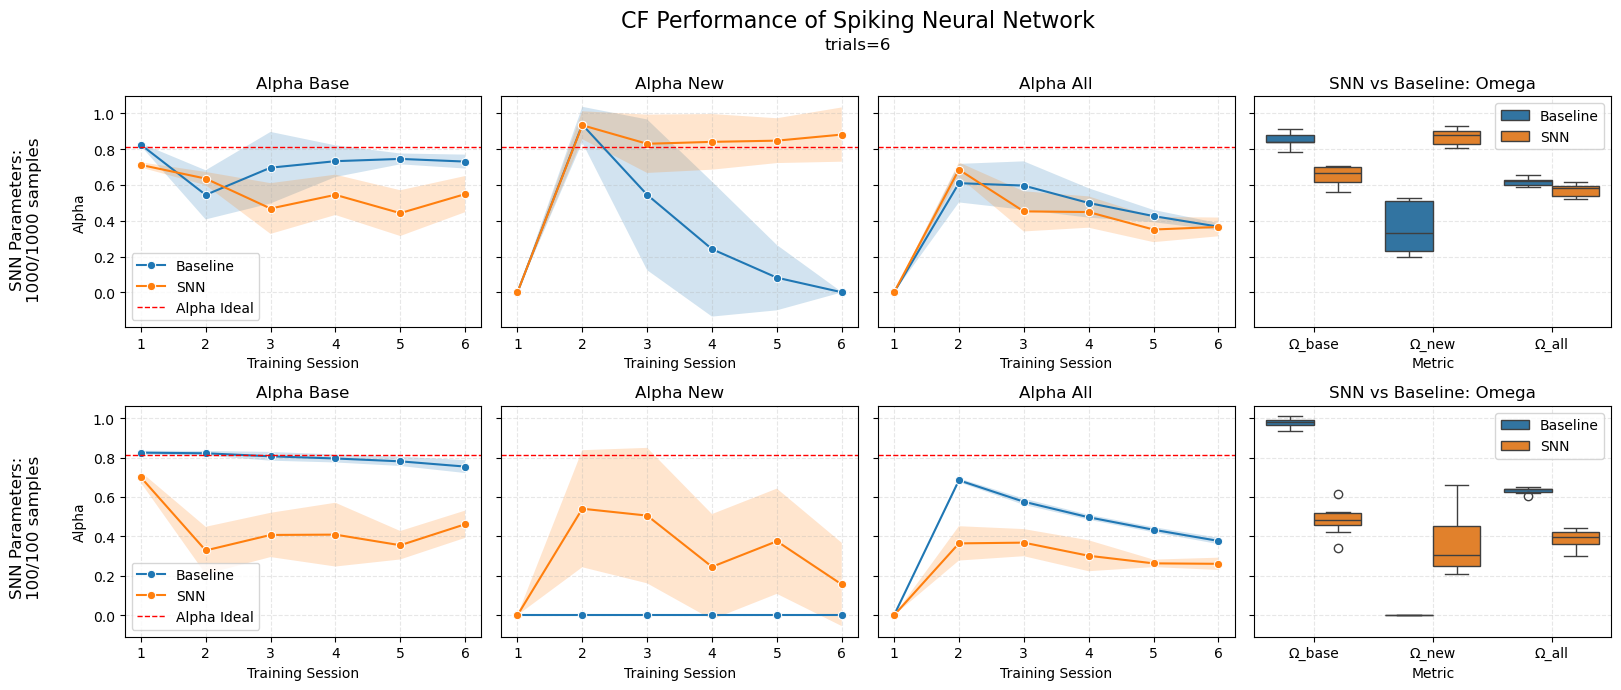

In [299]:
df_snn = get_experiment("accc798", "#2_SNN")
df_snn2 = get_experiment("accc798", "#2_SNNb")
dfs = [df_snn, df_snn2]


fig, axes = plt.subplots(len(dfs), 4, figsize=(16, 7), sharey='row')
fig.subplots_adjust(hspace=0.7, wspace=0.3)

titles = ["SNN Parameters:\n1000/1000 samples", "SNN Parameters:\n100/100 samples"]

#overall plot title
fig.suptitle("CF Performance of Spiking Neural Network", fontsize=16)
fig.text(0.5, 0.93, f"trials={df_pygad.shape[0]}", ha='center', va='center', size='large')

for i, (df, title) in enumerate(zip(dfs, titles)):
    plot_session_evolution(df, model="SNN", title=title, ax_list=axes[i, :])
    plot_cf_metrics(df, model="SNN", title="Omega", ax=axes[i, -1])
    
    y_pos = 0.68 - i * 0.44
    fig.text(-0.02, y_pos, title, ha='center', va='center', size='large', rotation=90)

plt.tight_layout(rect=[0, 0, 0.98, 0.96])
plt.show()

## baseline vs GA

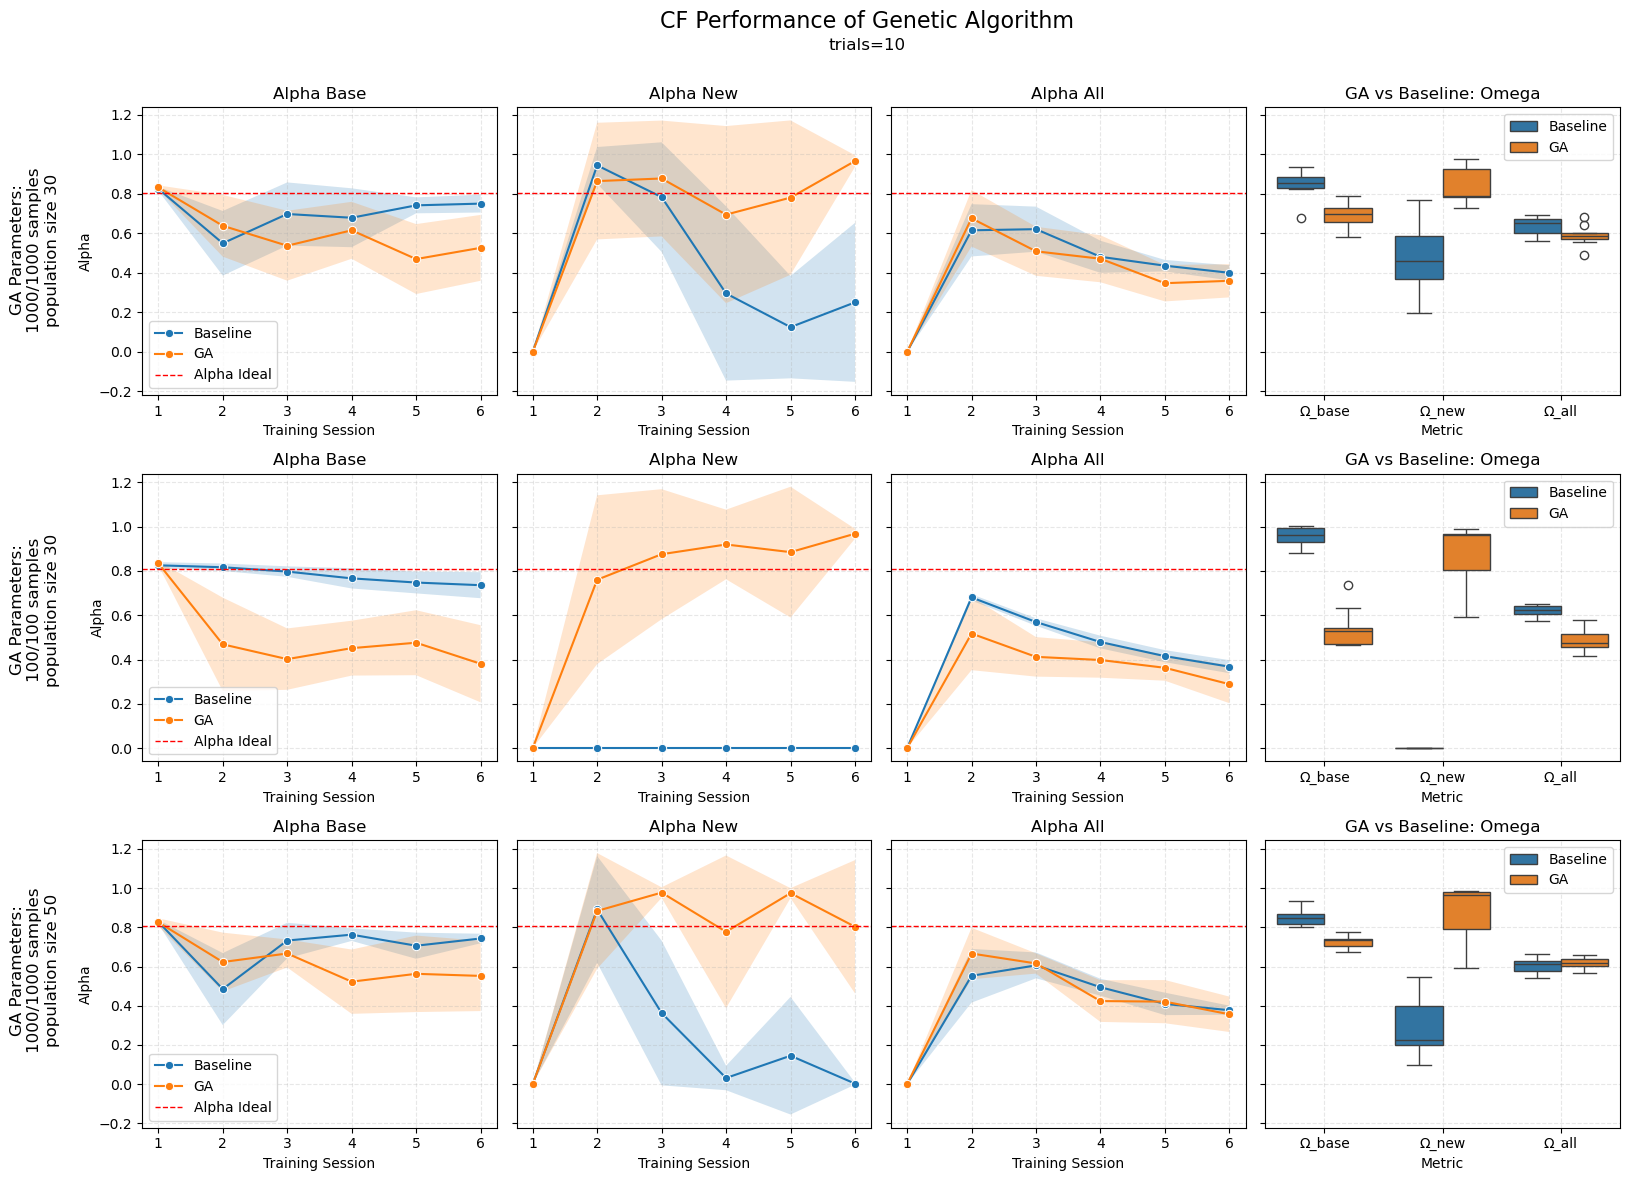

In [295]:
df_ga = get_experiment("e5af9d9", "#1_lasso")
df_ga2 = get_experiment("e5af9d9", "#1_16020914_NO")
df_ga3 = get_experiment("e5af9d9", "#1_16020450_IS")

fig, axes = plt.subplots(3, 4, figsize=(16, 12), sharey='row')
fig.subplots_adjust(hspace=0.7, wspace=0.3)

dfs = [df_ga, df_ga3, df_ga2]
titles = ["GA Parameters:\n1000/1000 samples\npopulation size 30", "GA Parameters:\n100/100 samples\npopulation size 30", "GA Parameters:\n1000/1000 samples\npopulation size 50"]

#overall plot title
fig.suptitle("CF Performance of Genetic Algorithm", fontsize=16)
#subtitle small
fig.text(0.5, 0.95, f"trials={df_ga.shape[0]}", ha='center', va='center', size='large')

for i, (df, title) in enumerate(zip(dfs, titles)):
    plot_session_evolution(df, model="GA", title=title, ax_list=axes[i, :])
    plot_cf_metrics(df, model="GA", title="Omega", ax=axes[i, -1])
    
    y_pos = 0.78 - i * 0.3  
    fig.text(-0.02, y_pos, title, ha='center', va='center', size='large', rotation=90)

plt.tight_layout(rect=[0, 0, 0.98, 0.96])
plt.show()


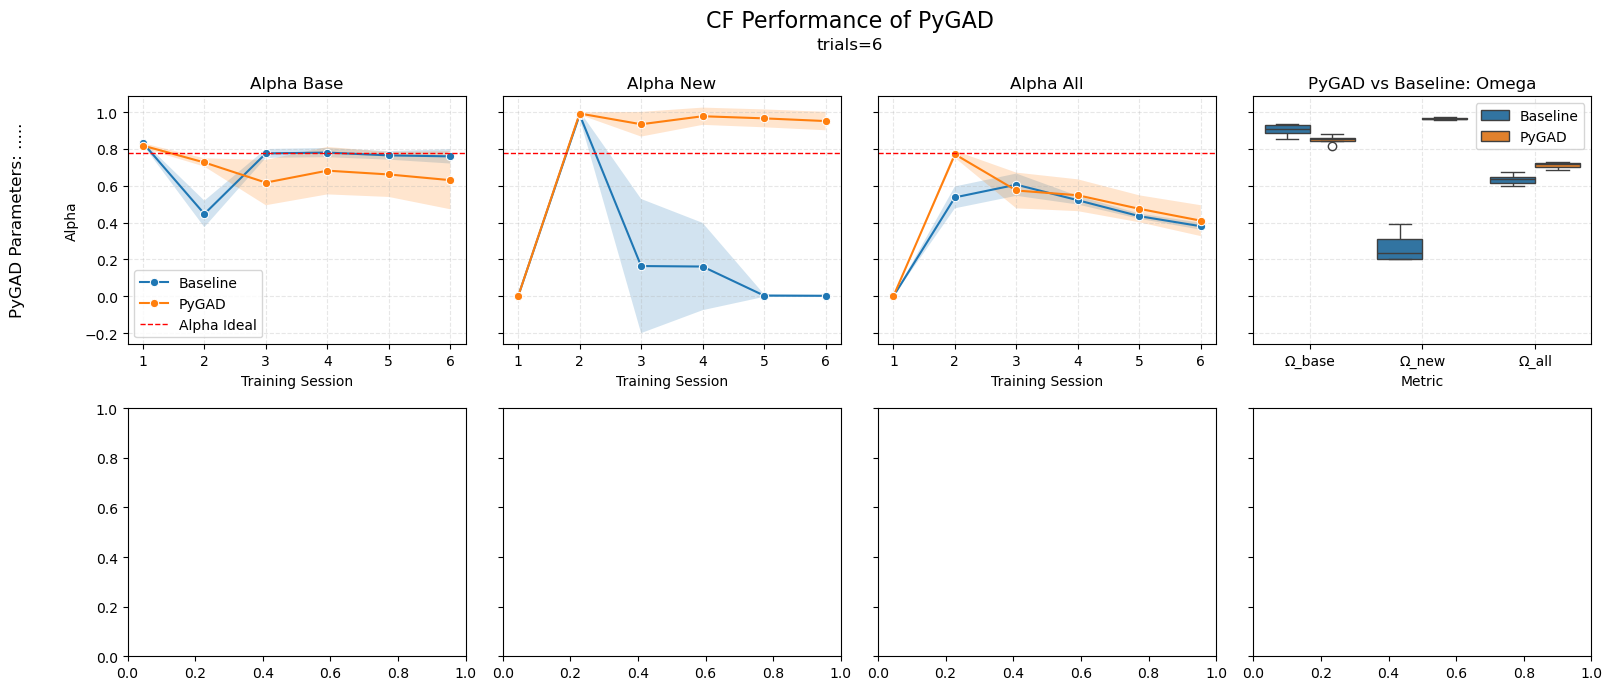

In [298]:
df_pygad = get_experiment("yi", "pygad_fmnist")

fig, axes = plt.subplots(2, 4, figsize=(16, 7), sharey='row')
fig.subplots_adjust(hspace=0.7, wspace=0.3)

dfs = [df_pygad]
titles = ["PyGAD Parameters: ....."]

#overall plot title
fig.suptitle("CF Performance of PyGAD", fontsize=16)
fig.text(0.5, 0.93, f"trials={df_pygad.shape[0]}", ha='center', va='center', size='large')

for i, (df, title) in enumerate(zip(dfs, titles)):
    plot_session_evolution(df, model="PyGAD", title=title, ax_list=axes[i, :])
    plot_cf_metrics(df, model="PyGAD", title="Omega", ax=axes[i, -1])
    
    y_pos = 0.68 - i * 0.44
    fig.text(-0.02, y_pos, title, ha='center', va='center', size='large', rotation=90)

plt.tight_layout(rect=[0, 0, 0.98, 0.96])
plt.show()
